# **Analysis of Most Streamed Spotify Songs**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spotify_streaming_df = pd.read_csv('data/spotify_most_streamed_songs.csv')
spotify_streaming_df

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,B,Major,80,89,83,31,0,8,4,Not Found
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,C#,Major,71,61,74,7,0,10,4,https://i.scdn.co/image/ab67616d0000b2730656d5...
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,F,Major,51,32,53,17,0,31,6,https://i.scdn.co/image/ab67616d0000b273e85259...
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,A,Major,55,58,72,11,0,11,15,https://i.scdn.co/image/ab67616d0000b273e787cf...
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,A,Minor,65,23,80,14,63,11,6,https://i.scdn.co/image/ab67616d0000b273ab5c9c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022,11,3,953,0,91473363,61,...,A,Major,60,24,39,57,0,8,3,https://i.scdn.co/image/ab67616d0000b2730f5397...
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870,4,...,F#,Major,42,7,24,83,1,12,6,https://i.scdn.co/image/ab67616d0000b273e0b60c...
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683,2,...,C#,Major,80,81,67,4,0,8,6,Not Found
951,En La De Ella,"Feid, Sech, Jhayco",3,2022,10,20,1320,0,133895612,29,...,C#,Major,82,67,77,8,0,12,5,Not Found


Feature descriptions from the kaggle posting:

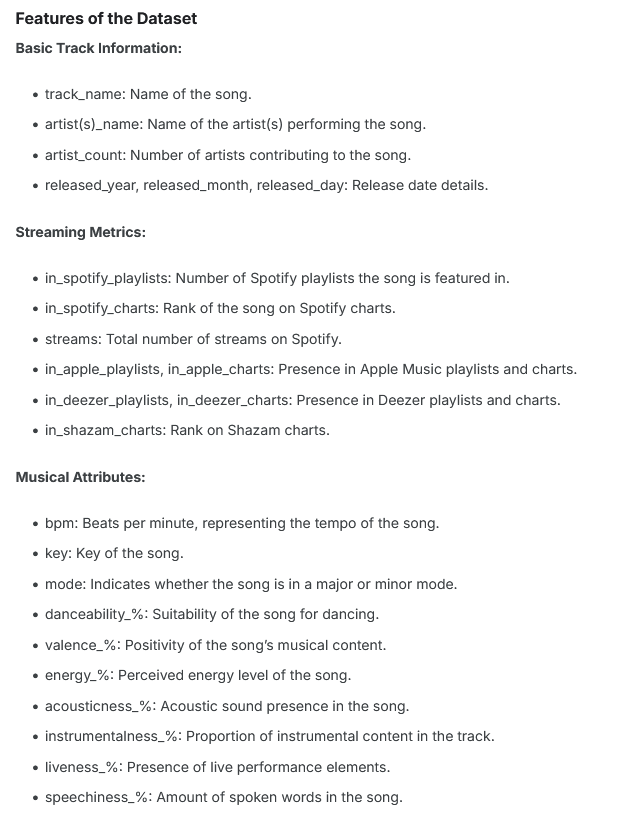

# **Cleaning the Data**

## **The Dirty Data**

In [3]:
spotify_streaming_df.dtypes

,0
track_name,object
artist(s)_name,object
artist_count,int64
released_year,int64
released_month,int64
released_day,int64
in_spotify_playlists,int64
in_spotify_charts,int64
streams,object
in_apple_playlists,int64


There are a few columns whose datatypes need to be corrected as shown in the table below:

| Column | Description |
| ------ | ----------- |
| streams | The number of streams the songs has on spotify |
| in_deezer_playlists | The number of deezer playlists the song is in |
| in_shazam_charts | The ranking of the song on shazam charts |

The data in these columns is all strings, but it would be way more useful as ints.

In [4]:
# find num NA in each column
print(f'Col{22*" "}Number of NA')
print(40 * '-')
for col in spotify_streaming_df.columns:
  print(f'{col}{(25 - len(col)) * " "}{len(spotify_streaming_df[spotify_streaming_df[col].isna()])}')

print()
print(f'Total number of rows: {len(spotify_streaming_df)}')

Col                      Number of NA
----------------------------------------
track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts         50
bpm                      0
key                      95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
cover_url                0

Total number of rows: 953


The only columns with missing values are in_shazam_charts and key where the number of missing values is 5.25% and 9.97% of the total data respectively.

There are too many missing values to simply drop those rows, but fortunately those features aren't as central to the focus of the dataset.

It might be possible to obtain the missing keys for songs from the Spotify API if we need them later.

In [5]:
# check for duplicate tracks
num_tracks = len(spotify_streaming_df['track_name'])
num_unique_tracks = len(spotify_streaming_df['track_name'].unique())
dupe_check = "dupes detected" if num_tracks != num_unique_tracks else "no dupes detected"

print(dupe_check)
print(f'# of dupes: {num_tracks - num_unique_tracks}')

dupes detected
# of dupes: 10


It would appear that there are some tracks which share the same name.

In [6]:
dupes = spotify_streaming_df['track_name'].mode()
dupes

,track_name
0,About Damn Time
1,Daylight
2,Die For You
3,Flowers
4,Let It Snow! Let It Snow! Let It Snow!
5,Miss You
6,Numb
7,SNAP
8,SPIT IN MY FACE!
9,Take My Breath


The above are the 10 duplicate tracks.

In [7]:
spotify_streaming_df[spotify_streaming_df['track_name'] == 'About Damn Time']

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
372,About Damn Time,Lizzo,1,2022,7,15,2332,2,723894473,0,...,A#,Minor,84,72,74,10,0,34,7,https://i.scdn.co/image/ab67616d0000b273b817e7...
764,About Damn Time,Lizzo,1,2022,4,14,9021,0,723894473,242,...,A#,Minor,84,72,74,10,0,34,7,https://i.scdn.co/image/ab67616d0000b273b817e7...


In [8]:
spotify_streaming_df[spotify_streaming_df['track_name'] == 'Take My Breath']

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
512,Take My Breath,The Weeknd,1,2021,8,6,2597,0,130655803,17,...,A#,Minor,70,35,77,1,0,26,4,https://i.scdn.co/image/ab67616d0000b2734ab252...
616,Take My Breath,The Weeknd,1,2021,8,6,6392,0,432702334,174,...,G#,Major,75,53,74,2,0,11,5,https://i.scdn.co/image/ab67616d0000b2734ab252...


It looks like some of the duplicate tracks aren't necessarily duplicates as seen with Take My Breath by The Weeknd as the key, mode, and a few other traits differ.

However, in the case of About Damn Time by Lizzo, it looks like the only thing different between the two tracks is the release date and the metrics related to streams, charts, and playlists.

In order to see how many of the 10 dupes are "true dupes", let's check if they share more than just the track name.

In [9]:
dupe_traits = [
    'artist(s)_name',
    'artist_count',
    'key',
    'bpm',
    'mode',
    'danceability_%',
    'valence_%',
    'energy_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

true_dupes = 0
for dupe in dupes:
  dupe_data = spotify_streaming_df[spotify_streaming_df['track_name'] == dupe]

  track1 = dupe_data.iloc[0]
  track2 = dupe_data.iloc[1]

  if track1[dupe_traits].eq(track2[dupe_traits]).all():
    print(f'True dupe detected: {track1["track_name"]}')
    true_dupes += 1

print(f'# of true dupes: {true_dupes}')

True dupe detected: About Damn Time
# of true dupes: 1


Looks like About Damn Time by Lizzo is the only real dupe in the dataset. Since it's only 1 track of 953, leaving it in won't cause any serious problems.

In [10]:
spotify_streaming_df[['released_year', 'released_month', 'released_day']]

,released_year,released_month,released_day
0,2023,7,14
1,2023,3,23
2,2023,6,30
3,2019,8,23
4,2023,5,18
...,...,...,...
948,2022,11,3
949,2022,10,21
950,2022,11,3
951,2022,10,20


The released_year, released_month, and released_day columns are good, but they would be even better as one column containing datetimes.

## **Getting the Grime Off (Actually Cleaning the Data)**

The first order of business is to convert the problematic columns (in_shazam_charts, in_deezer_playlists, and streams) from strings to ints.

In [11]:
spotify_streaming_df['in_deezer_playlists'] = spotify_streaming_df['in_deezer_playlists'].str.replace(',', '').astype(int)

The first one goes well, but it is the only column of the three that can be casted without errors.

The next column, in_shazam_charts fails because there are missing values.

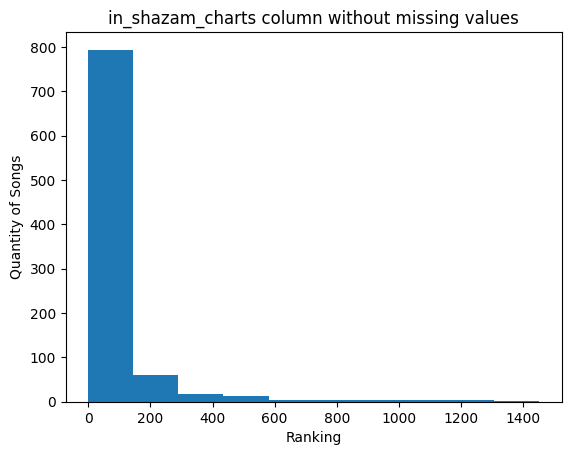

In [12]:
shazam_charts_without_na = spotify_streaming_df['in_shazam_charts'].dropna().str.replace(',', '').astype(int)

fig, ax = plt.subplots()

ax.set_title('in_shazam_charts column without missing values')
ax.set_xlabel('Ranking')
ax.set_ylabel('Quantity of Songs')
ax.hist(shazam_charts_without_na);

It's pretty safe to replace the missing values in the in_shazam_charts column with 0, seeing as that's where a vast majority of the data lies and it makes sense that most songs wouldn't be on the charts anyways.

In [13]:
spotify_streaming_df['in_shazam_charts'] = spotify_streaming_df['in_shazam_charts'].fillna('0').str.replace(',', '').astype(int)

The last column to convert to ints is the streams column which represents each song's number of streams on Spotify. The reason it fails to cast normally is due to a particular row having a malformed data point.

In [14]:
spotify_streaming_df[spotify_streaming_df['streams'].apply(lambda x: not(x.isdigit()))]

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
574,Love Grows (Where My Rosemary Goes),Edison Lighthouse,1,1970,1,1,2877,0,BPM110KeyAModeMajorDanceability53Valence75Ener...,16,...,A,Major,53,75,69,7,0,17,3,https://i.scdn.co/image/ab67616d0000b2739a0011...


Since it is a single row of 953 (0.105% of the data), it is fine to remove.

Once it is removed, the conversion is successful.

In [15]:
spotify_streaming_df.drop(574, inplace=True)
spotify_streaming_df['streams'] = spotify_streaming_df['streams'].astype(int)

Combining the released_year, released_month, and released_day columns into a single release_date column is pretty straightforward.

In [16]:
col_mapping = {
    'released_year': 'year',
    'released_month': 'month',
    'released_day': 'day'
}

release_dates = pd.to_datetime(spotify_streaming_df.rename(columns=col_mapping)[['year', 'month', 'day']])
spotify_streaming_df.insert(3, 'release_date', release_dates)
spotify_streaming_df.drop(columns=['released_year', 'released_month', 'released_day'], inplace=True)

Now lets see the data after all the cleaning is done.

In [17]:
spotify_streaming_df

,track_name,artist(s)_name,artist_count,release_date,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023-07-14,553,147,141381703,43,263,45,...,B,Major,80,89,83,31,0,8,4,Not Found
1,LALA,Myke Towers,1,2023-03-23,1474,48,133716286,48,126,58,...,C#,Major,71,61,74,7,0,10,4,https://i.scdn.co/image/ab67616d0000b2730656d5...
2,vampire,Olivia Rodrigo,1,2023-06-30,1397,113,140003974,94,207,91,...,F,Major,51,32,53,17,0,31,6,https://i.scdn.co/image/ab67616d0000b273e85259...
3,Cruel Summer,Taylor Swift,1,2019-08-23,7858,100,800840817,116,207,125,...,A,Major,55,58,72,11,0,11,15,https://i.scdn.co/image/ab67616d0000b273e787cf...
4,WHERE SHE GOES,Bad Bunny,1,2023-05-18,3133,50,303236322,84,133,87,...,A,Minor,65,23,80,14,63,11,6,https://i.scdn.co/image/ab67616d0000b273ab5c9c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022-11-03,953,0,91473363,61,13,37,...,A,Major,60,24,39,57,0,8,3,https://i.scdn.co/image/ab67616d0000b2730f5397...
949,Bigger Than The Whole Sky,Taylor Swift,1,2022-10-21,1180,0,121871870,4,0,8,...,F#,Major,42,7,24,83,1,12,6,https://i.scdn.co/image/ab67616d0000b273e0b60c...
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022-11-03,573,0,73513683,2,0,7,...,C#,Major,80,81,67,4,0,8,6,Not Found
951,En La De Ella,"Feid, Sech, Jhayco",3,2022-10-20,1320,0,133895612,29,26,17,...,C#,Major,82,67,77,8,0,12,5,Not Found


# **HYPOTHESIS NUMBER ??**


**PART 1: Building Our Hypothesis**

A common popular myth in music composition is that music in minor mode tend to be sadder and more moody. We would like to test if there is actually any meaningful correlation between minor modes and the music actually being sadder. This can be done on our data set in the form of looking at how songs in major and minor keys vary in danceability and energy and see if there is a statistically significant difference in these two categories. We can now propose a null and alternative hypothesis for both energy and danceability:

**ENERGY ANALYSIS:**

$H_{0}$ : There is no difference between the distribution of energy level of a song and whether or not it is in a minor mode versus major mode.

$H_{A}$ : There is a meaningful difference between the distribution of energy level of a song and whether or not it is in a minor mode versus major mode.


**DANCEABILITY ANALYSIS:**

$H_{0}$ : There is no difference between the distribution of danceability of a song and whether or not it is in a minor mode versus major mode.

$H_{A}$ : There is a meaningful difference between the distribution of danceability of a song and whether or not it is in a minor mode versus major mode.

We will set the alpha level to be the standard 0.05 and compare our obtained values to this in order to assess statistical significance.

<br>
**Part 2: Data Analysis and Picking our Test to Use**

From our dataset we can see that major and minor modes are two quantitative data points and can be viewed as categorical for when we assess. As for danceability and energy level, both are given as percentages. We can first look at the distribution of both categories overall and then break them into a couple discrete categories to group them by judging by how the distribution of both comes out. We would like to create the following categories for both danceability and energy; High, Medium, Low. The way we will do this is to look at what percentage of the data falls below the 33 percentile and call this Low Energy/Danceability, data between the 33 and 66 percentile as Medium Energy/Danceability and between 66 and 100 percentile as High Energy/Danceability. The code for calculating these is provided below:

In [18]:
spotify_streaming_df['danceability_%'].describe(percentiles=[.33, .66, 1.0])

,danceability_%
count,952.000000
mean,66.984244
std,14.631282
min,23.000000
33%,61.000000
50%,69.000000
66%,75.000000
100%,96.000000
max,96.000000


In [19]:
spotify_streaming_df['energy_%'].describe(percentiles=[.33, .66, 1.0])

,energy_%
count,952.000000
mean,64.274160
std,16.558517
min,9.000000
33%,58.000000
50%,66.000000
66%,73.000000
100%,97.000000
max,97.000000


From our calculations above, we can see break down both categories by the following categories and classifications:


**Danceability Breakdown**

| Category | Danceability% In Range |
|---|---|
| Low | 0 - 61 |
| Medium | 61-75 |
| High | 75-96 |

<br>

**Energy Breakdown**



| Category | Energy% In Range |
|---|---|
| Low | 0 - 58 |
| Medium | 58-73 |
| High | 73-97 |
<br>

By making these two values into categorical groups, we now have our independent variable, Major vs Minor Mode, as a categorical value and our dependent variables, Energy % and Danceability % as categorical values as well. Thus the most appropriate statistical test for our data will be **Chi Square Tests** to see if major and minor modes result in different categorical distributions for each dependent variable or not. Now we are ready to break up our data into the aforementioned groups and then analyze the data.

**Part 3: Processing Data and Graphing Outcome**

Lets go ahead and clean up our data so it is groups by major and minor modes and how each break down into the distinct categories:

In [20]:
hypo_df = spotify_streaming_df.copy()
def categorize_energy(energy):
    if energy <= 58:
        return 'Low'
    elif energy <= 73:
        return 'Medium'
    else: return 'High'

hypo_df['energy_%'] = hypo_df['energy_%'].apply(categorize_energy)
def categorize_energy(danceability):
    if danceability <= 61:
        return 'Low'
    elif danceability <= 75:
        return 'Medium'
    else: return 'High'

hypo_df['danceability_%'] = hypo_df['danceability_%'].apply(categorize_energy)
energy_breakdown = hypo_df[['mode', 'energy_%']].groupby(['mode', 'energy_%']).size().reset_index(name='counts')
energy_breakdown = energy_breakdown.pivot(index='mode', columns='energy_%', values='counts')
energy_breakdown

energy_%,High,Low,Medium
mode,,,
Major,176,200,173
Minor,135,123,145


In [21]:
danceability_breakdown = hypo_df[['mode', 'danceability_%']].groupby(['mode', 'danceability_%']).size().reset_index(name='counts')
danceability_breakdown = danceability_breakdown.pivot(index='mode', columns='danceability_%', values='counts')
danceability_breakdown

danceability_%,High,Low,Medium
mode,,,
Major,151,219,179
Minor,155,109,139


Now that we have the data broken down into the distinct groups, we can now graph each one to see how the distributions look:

Text(0, 0.5, 'Count')

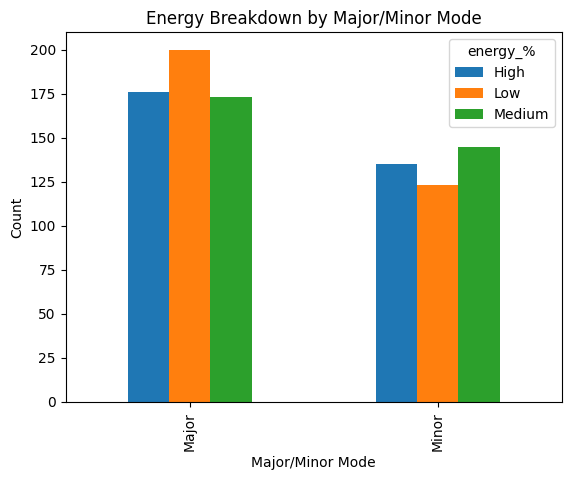

In [22]:
energy_graph = energy_breakdown.plot(kind='bar')
energy_graph.set_title('Energy Breakdown by Major/Minor Mode')
energy_graph.set_xlabel('Major/Minor Mode')
energy_graph.set_ylabel('Count')

Text(0.5, 0, 'Major/Minor Mode')

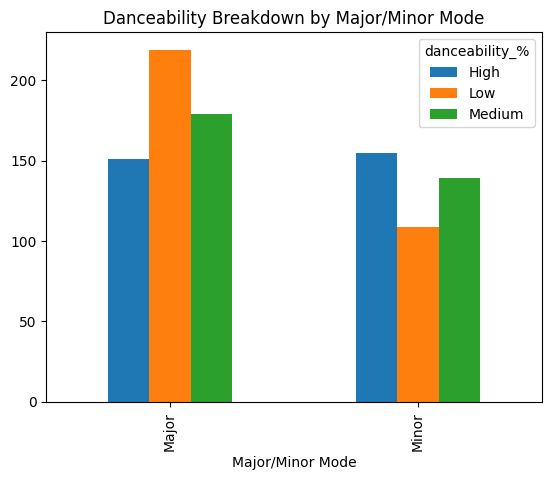

In [23]:
danceability_breakdown_graph = danceability_breakdown.plot(kind='bar')
danceability_breakdown_graph.set_title('Danceability Breakdown by Major/Minor Mode')
danceability_breakdown_graph.set_xlabel('Major/Minor Mode')

From our graphs above, we can do some quick general analysis and see that the distribution of energy by mode looks relatively similar but the danceability distribution looks significantly different. We can now verify this by doing chi square tests for both energy and danceability. This process first involves creating contingency tables for each and then conducting the chi square test on each:

In [24]:
from scipy import stats


In [27]:
contingency_table = pd.crosstab(hypo_df['mode'], hypo_df['danceability_%'])
contingency_table
stats.chi2_contingency(contingency_table)

Chi2ContingencyResult(statistic=20.054907162567982, pvalue=4.417049254558972e-05, dof=2, expected_freq=array([[176.46428571, 189.1512605 , 183.38445378],
       [129.53571429, 138.8487395 , 134.61554622]]))

In [28]:
contingency_table_energy = pd.crosstab(hypo_df['mode'], hypo_df['energy_%'])
contingency_table_energy
stats.chi2_contingency(contingency_table_energy)

Chi2ContingencyResult(statistic=3.9282250308555486, pvalue=0.1402803280146365, dof=2, expected_freq=array([[179.34768908, 186.26785714, 183.38445378],
       [131.65231092, 136.73214286, 134.61554622]]))

**PART 4: Conclusion**

From our Chi Squared tests we can see that our initial observations of the graphs did in fact prove to be correct. The P-Value of the distribution of Major/Minor modes for danceability is 0.00004417 which is far below our set alpha of 0.05 and thus we **REJECT** our null hypothesis and accept our alternate hypothesis that there is a significant difference between major and minor modes and the danceability levels of songs within those modes. In this casem it is as we expected and the danceability is lower for minor modes.

On the other hand, the Chi Squared Analysis returned for Major/Minor modes vs Energy distribution gave back a P-Value of 0.14 which is not below our alpha of 0.05 and we **fail** to reject our null hypothesis and conclude that there is no significant difference of energy distribution of songs for major vs minor modes.


## **Hypothesis Number ??** 

Looking at the dataframe, I would like to test the beats per minute (bpm) in relation to its popularity:

Since we do not know if the bpm is normally distributed we can check by graphing the bpm


So now lets start with our hypothesis:

* Null Hypothesis: BPM has no effect on the amount of streams of a song

* Alternative Hypothesis: BPM has an effect on the amount of streams of a song


Let us create a visualization for our hypothesis:

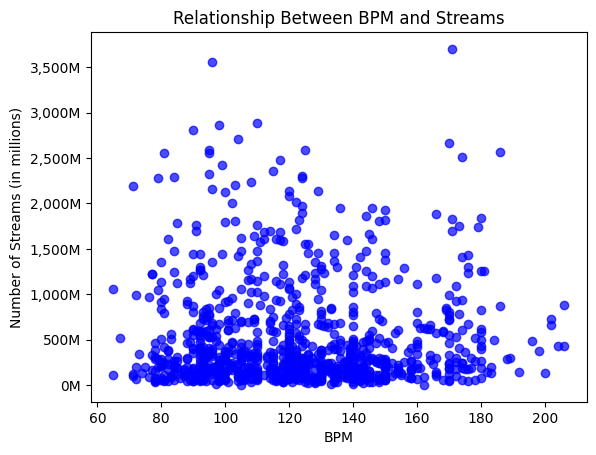

In [ ]:
from matplotlib.ticker import FuncFormatter

plt.scatter(spotify_streaming_df['bpm'],spotify_streaming_df['streams'], color='blue',alpha=.7)

plt.title('Relationship Between BPM and Streams')
plt.xlabel('BPM')
plt.ylabel('Number of Streams (in millions)')

def millions(x, pos):
    return f'{int(x * 1e-6):,}M'

f = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(f)

plt.show()

Now that we have visualized the data, lets conduct a pearson coefficient test for our hypothesis

In [ ]:
import scipy.stats as stats

coefficient,pvalue = stats.pearsonr(spotify_streaming_df['bpm'], spotify_streaming_df['streams'])

print(f'The Pearson coefficient is {coefficient} \n and the pvalue is: {pvalue}')

The Pearson coefficient is -0.0024379081382717837 
 and the pvalue is: 0.9401178701572729


As we can see the pearson value is close to 0, and the pvalue, .95 is greater than .05
So therefore the data is insignificant and we fail to reject the null hypothesis.
The BPM of a song has no effect on the amount of streams it has.